We are building a Adaptive rag.It has two major features- i) dynamic query analysis with ii) adaptive/self correcting mechanisms. In this notebook I will design all the LLM calls 1. Query Routing, 2. Document Relevance Assessment, 3. Hallucination Detection, 4. Answer Quality Evaluation

In [29]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain.prompts import ChatPromptTemplate
from typing import Literal
from dotenv import load_dotenv
from langchain import hub
from sentence_transformers import SentenceTransformer

d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_dotenv()

True

In [143]:
# Create uery Router Chain. Query Router will provide either of the three outputs ['vectorstore', 'websearch', 'simple']. 
llm = ChatOpenAI(model = "gpt-3.5-turbo", temperature = 0.0, max_tokens = 100)

## Create a pydantic model for the query router structure output
class QueryRouterOutput(BaseModel):
    "Route a user query to most relevant datasource"
    datasource: Literal["vectorstore","websearch"] = Field(
        ..., description="Given a user query, route to the most relevant datasource. The options are 'vectorstore', 'websearch'"
    )

structured_llm_router = llm.with_structured_output(QueryRouterOutput)

system_prompt = """You are a query router to route user query to Vectorstore or websearch or simple. Vectorstore contains about agents, prompt engineering, adversial attacks. Use the vectorstore if the query is related to these topics. Use websearch if the query is not related to these topics."""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "query: {query}"),
    ]
)

query_router_chain = router_prompt | structured_llm_router

# Example usage of the query router chain
query_router_chain.invoke({"query": 'Hey, how are you?'})  # Should return 'vectorstore'

d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


QueryRouterOutput(datasource='websearch')

In [ ]:
# Now, let's create a retrieval grader chain. It will check for whether the retrieved documents are actually relevant to the user's question. The output will be either 'yes' or 'no'.

class RetrievalGraderOutput(BaseModel):
    "Check if the retrieved documents are relevant to the user's question"
    is_relevant: Literal["yes", "no"] = Field(
        ..., description="Check if the retrieved documents are relevant to the user's question. The options are 'yes' or 'no'."
    )

retrieval_grader = llm.with_structured_output(RetrievalGraderOutput)

system_prompt = """You are a retrieval grader to check if the retrieved documents are relevant to the user's question. If the retrieved documents are relevant, return 'yes'. If the retrieved documents are not relevant, return 'no'."""

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "query: {query}\nretrieved_docs: {retrieved_docs}"),
    ]
)

retrieval_grader_chain = grader_prompt | retrieval_grader

# Example usage of the retrieval grader chain
retrieval_grader_chain.invoke({
    "query": "What is the capital of France?",
    "retrieved_docs": "AI agents are autonomous programs that can perform tasks without human intervention. They can be used for a variety of purposes, such as data analysis, web scraping, and automation."})  # Should return 'no'


d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


RetrievalGraderOutput(is_relevant='no')

In [ ]:
# Now let's create a Hallucination Checker Chain. It will check if the LLM response is hallucinated or not. The output will be either 'yes' or 'no'.

class HallucinationCheckerOutput(BaseModel):
    "Check if the LLM response is hallucinated or not"
    is_hallucinated: Literal["yes", "no"] = Field(
        ..., description="Check if the LLM response is hallucinated or not. The options are 'yes' or 'no'."
    )

hallucination_checker = llm.with_structured_output(HallucinationCheckerOutput)

system_prompt = """You are a hallucination checker to check if the LLM response is hallucinated or not. If the LLM response is hallucinated, return 'yes'. If the LLM response is not hallucinated, and supported by a set of reteieved facts, return 'no'."""

hallucination_checker_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "retrieved_docs: {retrieved_docs}\nllm_response: {llm_response}"),
    ]
)

hallucination_checker_chain = hallucination_checker_prompt | hallucination_checker

# Example usage of the hallucination checker chain
hallucination_checker_chain.invoke({
    "retrieved_docs": "AI agents are autonomous programs that can perform tasks without human intervention. They can be used for a variety of purposes, such as data analysis, web scraping, and automation.",
    "llm_response": "The capital of France is Paris."})  # Should return 'yes'

d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


HallucinationCheckerOutput(is_hallucinated='yes')

In [ ]:
# Let's create a Answer quality checker chain. It will check if the LLM response is of good quality or not. The output will be either 'yes' or 'no'.

class AnswerQualityCheckerOutput(BaseModel):
    "Check if the LLM response is of good quality or not"
    is_good_quality: Literal["yes", "no"] = Field(
        ..., description="Check if the LLM response is of good quality or not. The options are 'yes' or 'no'."
    )

answer_quality_checker = llm.with_structured_output(AnswerQualityCheckerOutput)

system_prompt = """ You are an answer quality checker wheather the LLM response correctly answers the user's question. If the LLM response is of good quality, return 'yes'. If the LLM response is not of good quality, return 'no'."""

answer_quality_checker_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "query: {query}\nllm_response: {llm_response}"),
    ])

answer_quality_checker_chain = answer_quality_checker_prompt | answer_quality_checker

# Example usage of the answer quality checker chain
answer_quality_checker_chain.invoke({"query": "What is the capital of France?",
                                     "llm_response": "The capital of France is Paris."})  # Should return

d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


AnswerQualityCheckerOutput(is_good_quality='yes')

In [138]:
from langchain_core.messages import SystemMessage, HumanMessage

In [149]:
# messages = [
#     SystemMessage(content = "You are a query rewriter to rewrite the user's query to be more specific and clear. The rewritten query should be more focused and should help in retrieving more relevant documents."),
#     HumanMessage(content = f"The previous query was: {query}. This query is not specific enough. Please rewrite it to be more specific and clear. Do not write any additional introductory text or greetings.")
#     ]
# response = llm.invoke(messages)

system_prompt = """You are a query rewriter to rewrite the user's query to be more specific and clear. The rewritten query should be more focused and should help in retrieving more relevant documents. Do not write any additional introductory text or greetings."""
rewrite_query_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "query: {query}")
    ]
)
rewrite_query_chain = rewrite_query_prompt | llm

In [151]:
rewrite_query_chain.invoke({"query": "What is the weather today?"})  # Should return a more specific query like "What is the capital city of France?"

AIMessage(content='weather forecast for today', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 64, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C4ujR9skbqENYLW53BSNG5BpPa3Nv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--4b9d8e52-c6b5-4632-ad7e-98596e020fc8-0', usage_metadata={'input_tokens': 64, 'output_tokens': 4, 'total_tokens': 68, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [26]:
llm_generation = ChatOpenAI(model = "gpt-3.5-turbo", temperature = 0.0)

prompt = hub.pull("rlm/rag-prompt")

generation_chain = prompt | llm_generation

d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [28]:
generation_chain.invoke({"context": "AI agents are autonomous programs that can perform tasks without human intervention. They can be used for a variety of purposes, such as data analysis, web scraping, and automation.",
                         "question": "What is AI agents?"})  # Should return 'The

AIMessage(content='AI agents are autonomous programs that can perform tasks without human intervention. They are used for data analysis, web scraping, and automation.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 104, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C4jtLOL1Fctz9I227XbhVJCF94KqW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--46ada0b9-a94e-49a3-84c0-811a3743e6b9-0', usage_metadata={'input_tokens': 104, 'output_tokens': 26, 'total_tokens': 130, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [33]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# ## Example of a SentenceTransformer model usage
# # The sentences to encode
# sentences = [
#     "The weather is lovely today.",
#     "It's so sunny outside!",
#     "He drove to the stadium.",
# ]

# # 2. Calculate embeddings by calling model.encode()
# embeddings = embed_model.encode(sentences)
# print(embeddings.shape)

(3, 384)


In [50]:
# Create document ingetion pipeline
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import SentenceTransformerEmbeddings

In [ ]:
## We will provide a list of URLs to the WebBaseLoader to load the documents from the web.
urls = [
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
    "https://en.wikipedia.org/wiki/AI_agent",
    "https://en.wikipedia.org/wiki/Prompt_engineering",
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [39]:
docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
docs_list = [item for sublist in docs for item in sublist] ## Flatten the list of lists

In [47]:
## We are using tiktoken encoding to ensure accurate 250 token chunks for the LLM.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=10)

In [48]:
doc_split = text_splitter.split_documents(docs_list)  # Split the documents into chunks

In [51]:
# embed_model = SentenceTransformer("all-MiniLM-L6-v2")
embed_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\Abir\AppData\Local\Temp\ipykernel_4620\1085340454.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


In [52]:
## Create vectore store with documents
vector_store = Chroma.from_documents(
    documents = doc_split, 
    embedding = embed_model, 
    collection_name="adaptive_rag", 
    persist_directory="./.chroma"
    )

In [53]:
# Create retriever from the vector store
retriever = vector_store.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 3}  # Retrieve top 3 most similar documents
)

In [55]:
## Test the retriever
retriever.get_relevant_documents("What is AI agents?")  # Should return a list of documents related to the query

[Document(id='26b06125-c85a-4150-b96e-ed830a345e08', metadata={'source': 'https://en.wikipedia.org/wiki/AI_agent', 'language': 'en', 'title': 'Agentic AI - Wikipedia'}, page_content='Overview[edit]\nThe core concept of agentic AI is the use of AI agents to perform automated tasks but without human intervention.[1] While robotic process automation (RPA) and AI agents can be programmed to automate specific tasks or support rule-based decisions, the rules are usually fixed.[2] Agentic AI operates independently, making decisions through continuous learning and analysis of external data and complex data sets.[3] Functioning agents can require various AI techniques, such as natural language processing, machine learning (ML), and computer vision, depending on the environment.[1]'),
 Document(id='3b820bbf-1267-4a9b-a3e6-1fba445cd7e8', metadata={'title': 'Artificial intelligence - Wikipedia', 'language': 'en', 'source': 'https://en.wikipedia.org/wiki/Artificial_intelligence'}, page_content='Age

In [74]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.schema import Document

In [186]:
class AdaptiveRAGState(TypedDict):
    "State for the Adaptive RAG graph"
    query: str
    datasource: str
    retrieved_docs: list[str]
    is_relevant: str
    quality_checker: str
    llm_response: str

In [199]:
def query_router(state: AdaptiveRAGState):
    "Route the user query to the most relevant datasource"
    query = state["query"]
    response = query_router_chain.invoke({"query": query})
    # print(response.datasource)
    return {"datasource": response.datasource}

def query_router_decision(state: AdaptiveRAGState) -> Literal["retrieval_route", "websearch_route"]:
    "Route the user query to the most relevant datasource"
    datasource = state["datasource"]
    print("---ROUTE QUESTION---")
    if datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "retrieval_route"
    if datasource == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch_route"
    
def retrieval_route(state: AdaptiveRAGState):
    "Retrieve documents from the vector store"
    query = state["query"]
    print("---RETRIEVE---")
    retrieved_docs = retriever.get_relevant_documents(query)
    retrieved_docs_list = [doc.page_content for doc in retrieved_docs]
    return {"retrieved_docs": retrieved_docs_list}

def websearch_route(state: AdaptiveRAGState):
    "Perform web search to retrieve documents"
    # Placeholder for web search logic
    # For now, we will return an empty list
    query = state["query"]
    print(query)
    search_tool = DuckDuckGoSearchRun()
    print(search_tool)
    results = search_tool.invoke(str(query))  # Perform web search
    print(results)
    web_results = Document(page_content=results, metadata={"source": "websearch"})
    return {"retrieved_docs": web_results}

def retrieval_grader(state: AdaptiveRAGState) -> Literal["content_generation", "rewrite_query"]:
    "Check if the retrieved documents are relevant to the user's question"
    query = state["query"]
    retrieved_docs = state["retrieved_docs"]
    response = retrieval_grader_chain.invoke({"query": query, "retrieved_docs": retrieved_docs})
    if response.is_relevant == "yes":
        return "content_generation"
    if response.is_relevant == "no":
        return "rewrite_query"

def rewrite_query(state: AdaptiveRAGState):
    "Rewrite the user query to be more specific and clear"
    query = state["query"]
    response = rewrite_query_chain.invoke({"query": query})
    return {"query": response}  # Update the query in the state with the rewritten query

def content_generation(state: AdaptiveRAGState):
    "Generate content using the LLM"
    retrieved_docs = state["retrieved_docs"]
    query = state["query"]
    try:
        context = "\n".join(retrieved_docs)
    except TypeError:
        context = str(retrieved_docs)
    llm_response = generation_chain.invoke({"context": context, "question": query})
    return {"llm_response": llm_response}

def hallucination_checker(state: AdaptiveRAGState):
    "Check if the LLM response is hallucinated or not"
    retrieved_docs = state["retrieved_docs"]
    llm_response = state["llm_response"]
    response = hallucination_checker_chain.invoke({"retrieved_docs": retrieved_docs, "llm_response": llm_response})
    if response.is_hallucinated == "yes":
        return "not_approved"
    if response.is_hallucinated == "no":
        return "approved"
    
def answer_quality_checker(state: AdaptiveRAGState):
    "Check if the LLM response is of good quality or not"
    query = state["query"]
    llm_response = state["llm_response"]
    response = answer_quality_checker_chain.invoke({"query": query, "llm_response": llm_response})
    return {"quality_checker": response}

def endnote(state: AdaptiveRAGState):
    quality_checker = state["quality_checker"]
    if quality_checker == "yes":
        return "END"
    if quality_checker == "no":
        return "rewritequery"

In [164]:
# retrieval_route({"query": "What is AI agents?"})  # Should return a list of documents related to the query
# websearch_route({"query": "What is AI agents?"})  # Should return a list of documents related to the query

In [195]:
# Create Graph
graph = StateGraph(AdaptiveRAGState)

# Create node
graph.add_node("query_router",query_router)
graph.add_node("retrieval_route", retrieval_route)
graph.add_node("websearch_route", websearch_route)
graph.add_node("content_generation", content_generation)
graph.add_node("rewrite_query", rewrite_query)
# graph.add_node("hallucination_checker", hallucination_checker)
# graph.add_node("answer_quality_checker", answer_quality_checker)
# graph.add_node("retrieval_grader", retrieval_grader)


# Create edge
graph.add_edge(START, "query_router")
graph.add_conditional_edges("query_router", query_router_decision)
# graph.add_conditional_edges(START, query_router)
# graph.add_edge(query_router, "retrieval_route")
graph.add_conditional_edges("retrieval_route", retrieval_grader)
graph.add_conditional_edges("content_generation", hallucination_checker, {"not_approved": "content_generation", "approved": END})

# graph.add_conditional_edges("content_generation", hallucination_checker, {"not_approved": "content_generation", "approved": "answer_quality_checker"})
# graph.add_conditional_edges("answer_quality_checker",endnote,{"END": END, "rewritequery": "rewrite_query"})

# graph.add_edge(content_generation,"answer_quality_checker")

graph.add_edge("rewrite_query","retrieval_route")


# graph.add_edge(query_router, "websearch_route")
graph.add_edge("websearch_route", "content_generation")
graph.add_edge("content_generation", END)

# Complie
workflow = graph.compile()

# Run
workflow.invoke({"query": "What is AI agents?"}) 

vectorstore


{'query': 'What is AI agents?',
 'datasource': 'vectorstore',
 'retrieved_docs': ['Overview[edit]\nThe core concept of agentic AI is the use of AI agents to perform automated tasks but without human intervention.[1] While robotic process automation (RPA) and AI agents can be programmed to automate specific tasks or support rule-based decisions, the rules are usually fixed.[2] Agentic AI operates independently, making decisions through continuous learning and analysis of external data and complex data sets.[3] Functioning agents can require various AI techniques, such as natural language processing, machine learning (ML), and computer vision, depending on the environment.[1]',
  'Agents\nMain article: Agentic AI\nAI agents are software entities designed to perceive their environment, make decisions, and take actions autonomously to achieve specific goals. These agents can interact with users, their environment, or other agents. AI agents are used in various applications, including virtu

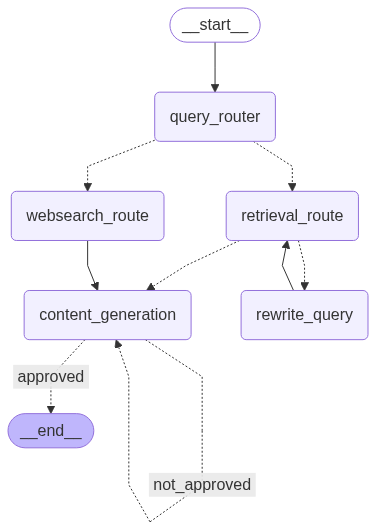

In [194]:
workflow

In [200]:
from dotenv import load_dotenv

load_dotenv()

# from graph.graph import app

def format_response(result):
    """Format the response from the graph for better readability"""
    if isinstance(result, dict) and "llm_response" in result:
        return result["llm_response"]
    elif isinstance(result, dict) and "generation" in result:
        return result["generation"]
    elif isinstance(result, dict) and "answer" in result:
        return result["answer"]
    else:
        # Fallback to string representation
        return str(result)


def main():
    print("=" * 60)
    print("🤖 Advanced RAG Chatbot")
    print("=" * 60)
    print("Welcome! Ask me anything or type 'quit', 'exit', or 'bye' to stop.")
    print("-" * 60)
    
    while True:
        try:
            # Get user input
            user_question = input("\n💬 You: ").strip()
            
            # Check for exit commands
            if user_question.lower() in ['quit', 'exit', 'bye', 'q']:
                print("\n👋 Goodbye! Thanks for chatting!")
                break
            
            # Skip empty inputs
            if not user_question:
                print("Please enter a question.")
                continue
            
            # Show processing indicator
            print("\n🤔 Bot: Thinking...")
            
            # Process the question through the graph
            result = workflow.invoke(input={"query": user_question})
            
            # Format and display the response
            response = format_response(result)
            print(f"\n🤖 Bot: {response}")
            
        except KeyboardInterrupt:
            print("\n\n👋 Goodbye! Thanks for chatting!")
            break
        except Exception as e:
            print(f"\n❌ Sorry, I encountered an error: {str(e)}")
            print("Please try asking your question again.")


if __name__ == "__main__":
    main()

🤖 Advanced RAG Chatbot
Welcome! Ask me anything or type 'quit', 'exit', or 'bye' to stop.
------------------------------------------------------------



🤔 Bot: Thinking...
vectorstore

🤖 Bot: content='Agentic AI is the use of AI agents to perform automated tasks without human intervention, operating independently through continuous learning and analysis of data. It can require various AI techniques like natural language processing, machine learning, and computer vision depending on the environment. Agentic AI has been named a top emerging technology for 2025 by research firm Forrester.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 487, 'total_tokens': 557, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C4vxwd6Tw1B0Cj73a4ne7ZpdKQ0AW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--ec29e7b3-46e0-45f7-b15

In [ ]:
def websearch_route(state: AdaptiveRAGState):
    "Perform web search to retrieve documents"
    # Placeholder for web search logic
    # For now, we will return an empty list
    query = state["query"]
    print(query)
    search_tool = DuckDuckGoSearchRun()
    results = search_tool.invoke(query)  # Perform web search
    print(results)
    web_results = Document(page_content=results, metadata={"source": "websearch"})
    return {"retrieved_docs": web_results}


websearch_route({"query": "How is the weather today?"})  # Should return a list of documents related to the query

How is the weather today?


d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


1 day ago · Get the latest hourly weather updates for India today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today's weather conditions in … Sunny mornings, rainy afternoons, or foggy nights—stay ahead of changing weather conditions with Times of India’s comprehensive weather forecasts. Get real-time updates on temperature, … 1 day ago · The weather today in India will be hot with temperatures reaching 80°F. During the evening and night time the temperatures will drop to 78 ° F. For deep dive information check out … 1 day ago · Detailed hourly weather forecast for today - including weather conditions, temperature, pressure, humidity, precipitation, dewpoint, wind, visibility, and UV index data. 1 day ago · Delhi-NCR Rain, Weather Today LIVE Updates: The rain led to waterlogging in several parts of the national capital and slowed traffic, inconveniencing commuters during the morning …


{'retrieved_docs': Document(metadata={'source': 'websearch'}, page_content="1 day ago · Get the latest hourly weather updates for India today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today's weather conditions in … Sunny mornings, rainy afternoons, or foggy nights—stay ahead of changing weather conditions with Times of India’s comprehensive weather forecasts. Get real-time updates on temperature, … 1 day ago · The weather today in India will be hot with temperatures reaching 80°F. During the evening and night time the temperatures will drop to 78 ° F. For deep dive information check out … 1 day ago · Detailed hourly weather forecast for today - including weather conditions, temperature, pressure, humidity, precipitation, dewpoint, wind, visibility, and UV index data. 1 day ago · Delhi-NCR Rain, Weather Today LIVE Updates: The rain led to waterlogging in several parts of the national capital and slowed traffic, inconveniencing commute

In [136]:
workflow.invoke({"query": "What is weather today?"})  # Should return a list of documents related to the query

websearch
What is weather today?
api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')


d:\abir\ai_ml_cv_projects\adaptive_rag\.venv\lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


Get the India weather forecast including weather radar and current conditions in India across major cities. 1 day ago · Get the latest hourly weather updates for India today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today's weather conditions in … 1 day ago · The weather today in India will be hot with temperatures reaching 80°F. During the evening and night time the temperatures will drop to 78 ° F. For deep dive information check out … Sunny mornings, rainy afternoons, or foggy nights—stay ahead of changing weather conditions with Times of India’s comprehensive weather forecasts. Get real-time updates on temperature, … 4 days ago · Get the latest Delhi weather updates! Check today’s forecast, temperature, humidity, hourly updates rain alerts. Stay prepared with real-time Delhi weather reports!


{'query': 'What is weather today?',
 'datasource': 'websearch',
 'retrieved_docs': Document(metadata={'source': 'websearch'}, page_content="Get the India weather forecast including weather radar and current conditions in India across major cities. 1 day ago · Get the latest hourly weather updates for India today. Detailed forecast including temperature, wind, rain, snow, and UV index. Stay informed about today's weather conditions in … 1 day ago · The weather today in India will be hot with temperatures reaching 80°F. During the evening and night time the temperatures will drop to 78 ° F. For deep dive information check out … Sunny mornings, rainy afternoons, or foggy nights—stay ahead of changing weather conditions with Times of India’s comprehensive weather forecasts. Get real-time updates on temperature, … 4 days ago · Get the latest Delhi weather updates! Check today’s forecast, temperature, humidity, hourly updates rain alerts. Stay prepared with real-time Delhi weather reports!")